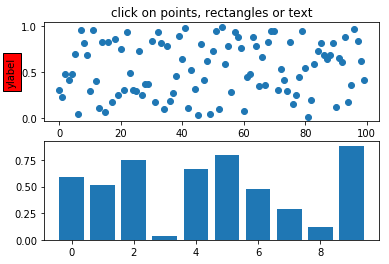

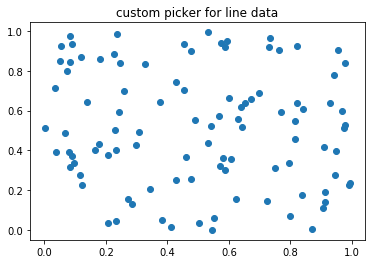

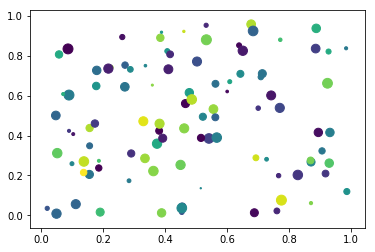

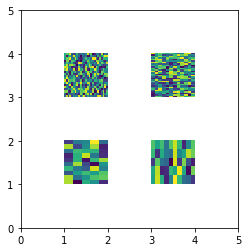

In [2]:
"""

You can enable picking by setting the "picker" property of an artist
(for example, a matplotlib Line2D, Text, Patch, Polygon, AxesImage,
etc...)

There are a variety of meanings of the picker property

    None -  picking is disabled for this artist (default)

    boolean - if True then picking will be enabled and the
      artist will fire a pick event if the mouse event is over
      the artist

    float - if picker is a number it is interpreted as an
      epsilon tolerance in points and the artist will fire
      off an event if it's data is within epsilon of the mouse
      event.  For some artists like lines and patch collections,
      the artist may provide additional data to the pick event
      that is generated, for example, the indices of the data within
      epsilon of the pick event

    function - if picker is callable, it is a user supplied
      function which determines whether the artist is hit by the
      mouse event.

         hit, props = picker(artist, mouseevent)

      to determine the hit test.  If the mouse event is over the
      artist, return hit=True and props is a dictionary of properties
      you want added to the PickEvent attributes


After you have enabled an artist for picking by setting the "picker"
property, you need to connect to the figure canvas pick_event to get
pick callbacks on mouse press events.  For example,

  def pick_handler(event):
      mouseevent = event.mouseevent
      artist = event.artist
      # now do something with this...


The pick event (matplotlib.backend_bases.PickEvent) which is passed to
your callback is always fired with two attributes:

  mouseevent - the mouse event that generate the pick event.  The
    mouse event in turn has attributes like x and y (the coordinates in
    display space, such as pixels from left, bottom) and xdata, ydata (the
    coords in data space).  Additionally, you can get information about
    which buttons were pressed, which keys were pressed, which Axes
    the mouse is over, etc.  See matplotlib.backend_bases.MouseEvent
    for details.

  artist - the matplotlib.artist that generated the pick event.

Additionally, certain artists like Line2D and PatchCollection may
attach additional meta data like the indices into the data that meet
the picker criteria (for example, all the points in the line that are within
the specified epsilon tolerance)

The examples below illustrate each of these methods.
"""

from __future__ import print_function
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.text import Text
from matplotlib.image import AxesImage
import numpy as np
from numpy.random import rand

if 1:  # simple picking, lines, rectangles and text
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.set_title('click on points, rectangles or text', picker=True)
    ax1.set_ylabel('ylabel', picker=True, bbox=dict(facecolor='red'))
    line, = ax1.plot(rand(100), 'o', picker=5)  # 5 points tolerance

    # pick the rectangle
    bars = ax2.bar(range(10), rand(10), picker=True)
    for label in ax2.get_xticklabels():  # make the xtick labels pickable
        label.set_picker(True)

    def onpick1(event):
        if isinstance(event.artist, Line2D):
            thisline = event.artist
            xdata = thisline.get_xdata()
            ydata = thisline.get_ydata()
            ind = event.ind
            print('onpick1 line:', zip(np.take(xdata, ind), np.take(ydata, ind)))
        elif isinstance(event.artist, Rectangle):
            patch = event.artist
            print('onpick1 patch:', patch.get_path())
        elif isinstance(event.artist, Text):
            text = event.artist
            print('onpick1 text:', text.get_text())

    fig.canvas.mpl_connect('pick_event', onpick1)

if 1:  # picking with a custom hit test function
    # you can define custom pickers by setting picker to a callable
    # function.  The function has the signature
    #
    #  hit, props = func(artist, mouseevent)
    #
    # to determine the hit test.  if the mouse event is over the artist,
    # return hit=True and props is a dictionary of
    # properties you want added to the PickEvent attributes

    def line_picker(line, mouseevent):
        """
        find the points within a certain distance from the mouseclick in
        data coords and attach some extra attributes, pickx and picky
        which are the data points that were picked
        """
        if mouseevent.xdata is None:
            return False, dict()
        xdata = line.get_xdata()
        ydata = line.get_ydata()
        maxd = 0.05
        d = np.sqrt((xdata - mouseevent.xdata)**2. + (ydata - mouseevent.ydata)**2.)

        ind = np.nonzero(np.less_equal(d, maxd))
        if len(ind):
            pickx = np.take(xdata, ind)
            picky = np.take(ydata, ind)
            props = dict(ind=ind, pickx=pickx, picky=picky)
            return True, props
        else:
            return False, dict()

    def onpick2(event):
        print('onpick2 line:', event.pickx, event.picky)

    fig, ax = plt.subplots()
    ax.set_title('custom picker for line data')
    line, = ax.plot(rand(100), rand(100), 'o', picker=line_picker)
    fig.canvas.mpl_connect('pick_event', onpick2)


if 1:  # picking on a scatter plot (matplotlib.collections.RegularPolyCollection)

    x, y, c, s = rand(4, 100)

    def onpick3(event):
        ind = event.ind
        print('onpick3 scatter:', ind, np.take(x, ind), np.take(y, ind))

    fig, ax = plt.subplots()
    col = ax.scatter(x, y, 100*s, c, picker=True)
    #fig.savefig('pscoll.eps')
    fig.canvas.mpl_connect('pick_event', onpick3)

if 1:  # picking images (matplotlib.image.AxesImage)
    fig, ax = plt.subplots()
    im1 = ax.imshow(rand(10, 5), extent=(1, 2, 1, 2), picker=True)
    im2 = ax.imshow(rand(5, 10), extent=(3, 4, 1, 2), picker=True)
    im3 = ax.imshow(rand(20, 25), extent=(1, 2, 3, 4), picker=True)
    im4 = ax.imshow(rand(30, 12), extent=(3, 4, 3, 4), picker=True)
    ax.axis([0, 5, 0, 5])

    def onpick4(event):
        artist = event.artist
        if isinstance(artist, AxesImage):
            im = artist
            A = im.get_array()
            print('onpick4 image', A.shape)

    fig.canvas.mpl_connect('pick_event', onpick4)


plt.show()